In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Point,Polygon
import contextily as ctx
import geopandas
import seaborn as sns

sns.set_theme(style="darkgrid")
import glob


In [3]:
dir_data = '../data/biximontrealrentals2019-33ea73/'
df_stations = pd.read_csv(dir_data+'Stations_2019.csv')


In [4]:
df_stations

,Code,name,latitude,longitude
0,10002,Métro Charlevoix (Centre / Charlevoix),45.478228,-73.569651
1,4000,Jeanne-d'Arc / Ontario,45.549598,-73.541874
2,4001,Graham / Brookfield,45.520075,-73.629776
3,4002,Graham / Wicksteed,45.516937,-73.640483
4,5002,St-Charles / Montarville,45.533682,-73.515261
...,...,...,...,...
614,7149,16e avenue / Jean-Talon,45.562440,-73.595333
615,7150,du Souvenir / Chomedey,45.551886,-73.744440
616,7151,Métro Montmorency (de l'Avenir / Jacques-Tétre...,45.558109,-73.719597
617,7152,Parc St-Claude (7e avenue / 8e rue),45.562668,-73.692362


In [5]:
mtl_map = geopandas.read_file('../data/limadmin-shp/LIMADMIN.shp')

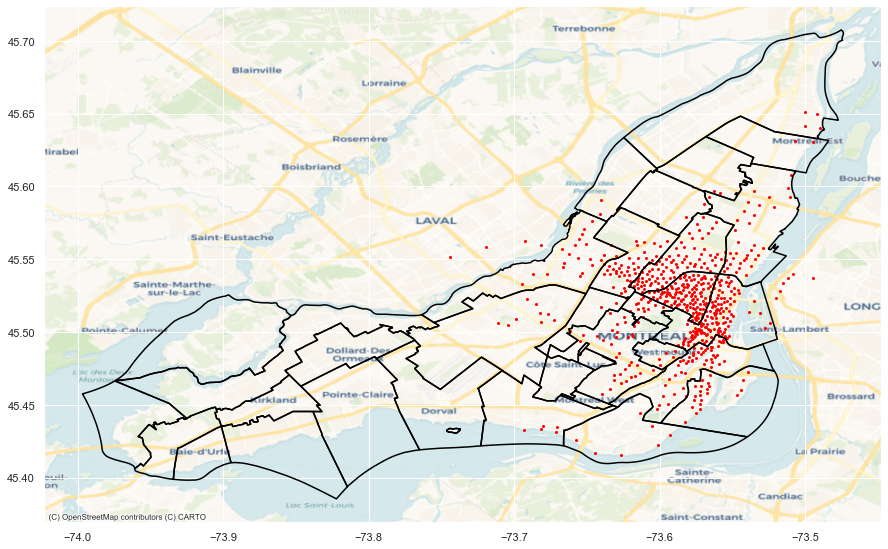

In [6]:
fig, ax = plt.subplots(1, sharex=True, figsize=(15,10))
mtl_map.boundary.plot(ax=ax, edgecolor='black')

# designate coordinate system
crs='EPSG:4326'
# zip x and y coordinates into single feature
geometry = [Point(xy) for xy in zip(df_stations['longitude'], df_stations['latitude'])]
# create GeoPandas dataframe
geo_df = geopandas.GeoDataFrame(df_stations,
 crs = crs,
 geometry = geometry)


geo_df.plot(ax=ax, color='red', markersize=4)
ctx.add_basemap(ax, crs=geo_df.crs.to_string(), source=ctx.providers.CartoDB.Voyager)



### Station info

In [7]:
print(df_stations.shape)

# are all stations unique? yes
print(df_stations[df_stations.duplicated(subset=['Code','name','longitude','latitude'])])

# anything missing a value? no
print(df_stations.isna().sum())


(619, 5)
Empty DataFrame
Columns: [Code, name, latitude, longitude, geometry]
Index: []
Code         0
name         0
latitude     0
longitude    0
geometry     0
dtype: int64


### MTL boundary file info

In [8]:
# 'Arrondissement' -> 'Borough'
# 'Ville liée' -> 'Linked City'...

print(mtl_map.shape)

print(mtl_map['TYPE'].unique())
print(mtl_map['NOM'].nunique())
print(mtl_map['NOM'].unique())

# what are the top five largest neighborhoods? are these sized in m^2 and m?
print('Area')
print(mtl_map.sort_values(by='AIRE', ascending=False)[['NOM','AIRE']].head())

print('Perimeter')
print(mtl_map.sort_values(by='PERIM', ascending=False)[['NOM','PERIM']].head())

(34, 10)
['Arrondissement' 'Ville liée']
34
['Outremont' 'LaSalle' 'Mont-Royal' 'Ville-Marie' 'Le Plateau-Mont-Royal'
 'Hampstead' 'Le Sud-Ouest' 'Rivière-des-Prairies-Pointe-aux-Trembles'
 'Lachine' 'Dorval' 'Montréal-Nord' "L'Île-Bizard-Sainte-Geneviève"
 'Kirkland' 'Dollard-des-Ormeaux' 'Senneville' 'Ahuntsic-Cartierville'
 'Côte-Saint-Luc' 'Saint-Léonard' 'Montréal-Ouest' 'Pointe-Claire'
 "L'Île-Dorval" 'Mercier-Hochelaga-Maisonneuve'
 'Côte-des-Neiges-Notre-Dame-de-Grâce' 'Rosemont-La Petite-Patrie'
 'Saint-Laurent' 'Beaconsfield' 'Villeray-Saint-Michel-Parc-Extension'
 'Westmount' 'Montréal-Est' 'Anjou' 'Pierrefonds-Roxboro'
 'Sainte-Anne-de-Bellevue' 'Verdun' "Baie-d'Urfé"]
Area
                                         NOM          AIRE
7   Rivière-des-Prairies-Pointe-aux-Trembles  5.004700e+07
24                             Saint-Laurent  4.307785e+07
11             L'Île-Bizard-Sainte-Geneviève  3.653251e+07
19                             Pointe-Claire  3.444652e+07
30        

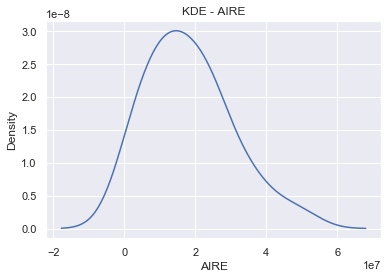

Text(0.5, 1.0, 'KDE - PERIM')

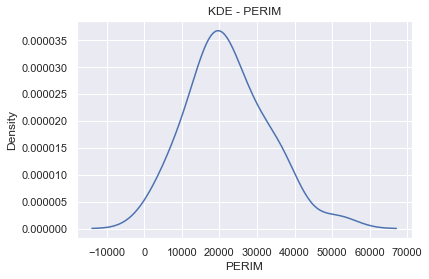

In [9]:

sns.kdeplot(data=mtl_map['AIRE'])
plt.title('KDE - AIRE')
plt.show()
sns.kdeplot(data=mtl_map['PERIM'])
plt.title('KDE - PERIM')

### Questions
1. Which neighborhood has the most Bixi stations?
2. How many neighbourhoods have no stations?
3. Which neighbourhood has the largest density of stations?
4. How many stations are outside of the mtl boundary?


In [10]:
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon

point = Point(0.5, 0.5)
polygon = Polygon([(0, 0), (0, 1), (1, 1), (1, 0)])
print(mtl_map.loc[0,'geometry'].contains(df_stations.loc[0, 'geometry']))

False


In [11]:
pt_counter = {}

for n in mtl_map.iterrows():
    pt_counter[n[1]['NOM']] = {'stations':[]}
    for pt in df_stations.iterrows():
        if n[1]['geometry'].contains(pt[1]['geometry']):
             pt_counter[n[1]['NOM']]['stations'].append(pt[1]['geometry'])
                
# need to get stations outside of polygons
mtl = mtl_map['geometry'].unary_union
pt_counter['outside mtl'] = {'stations':[]}
for pt in df_stations.iterrows():
    if not mtl.contains(pt[1]['geometry']):
        pt_counter['outside mtl']['stations'].append(pt[1]['geometry'])



In [12]:
df = pd.DataFrame(pt_counter).T
df['num_stations'] = df['stations'].apply(lambda x : len(x))

mtl_map.set_index('NOM', inplace=True)
df = df.join(mtl_map)

df['station_density'] = np.nan
df.loc[df['num_stations']>0, 'station_density'] = df['num_stations'] / df['AIRE'] 

In [13]:
print('Neighbourhood with the most stations')
print(df['num_stations'].idxmax())

print('Neighbourhoods with no stations')
print(df[df['num_stations']==0].shape[0])

print('Neighborhood with the most stations per m^2')
print(df['station_density'].idxmax())

print('Number of stations outside of MTL map')
print(df.loc['outside mtl']['num_stations'])

Neighbourhood with the most stations
Ville-Marie
Neighbourhoods with no stations
14
Neighborhood with the most stations per m^2
Le Plateau-Mont-Royal
Number of stations outside of MTL map
10


### Trip Data

In [15]:
trip_files = glob.glob(dir_data+"/OD*.csv")
trip_data = []
for file in trip_files:
    trip_data.append(pd.read_csv(file))

df_trips = pd.concat(trip_data)


/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (1,3) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [16]:
df_trips['start_date'] = pd.to_datetime(df_trips['start_date'])
df_trips['end_date'] = pd.to_datetime(df_trips['end_date'])
df_trips['is_member'] = df_trips['is_member'].astype(bool)
print(df_trips.info())
print(df_trips[['duration_sec', 'is_member']].describe())



<class 'pandas.core.frame.DataFrame'>
Int64Index: 5597845 entries, 0 to 933408
Data columns (total 6 columns):
 #   Column              Dtype         
---  ------              -----         
 0   start_date          datetime64[ns]
 1   start_station_code  object        
 2   end_date            datetime64[ns]
 3   end_station_code    object        
 4   duration_sec        int64         
 5   is_member           bool          
dtypes: bool(1), datetime64[ns](2), int64(1), object(2)
memory usage: 261.6+ MB
None
       duration_sec
count  5.597845e+06
mean   8.112804e+02
std    6.251589e+02
min    6.100000e+01
25%    3.690000e+02
50%    6.480000e+02
75%    1.090000e+03
max    7.199000e+03


#### Trips time series

In [17]:
df_trips.head()

,start_date,start_station_code,end_date,end_station_code,duration_sec,is_member
0,2019-08-01 00:00:03,7032,2019-08-01 00:24:57,6159,1493,True
1,2019-08-01 00:00:04,6219,2019-08-01 00:08:20,6201,495,True
2,2019-08-01 00:00:04,6368,2019-08-01 00:10:14,4000,609,True
3,2019-08-01 00:00:19,6154,2019-08-01 00:09:27,6163,547,True
4,2019-08-01 00:00:26,6039,2019-08-01 00:21:14,6402,1247,True


In [18]:
trips_per_day = df_trips.groupby([df_trips['start_date'].dt.date])['start_date'].count()

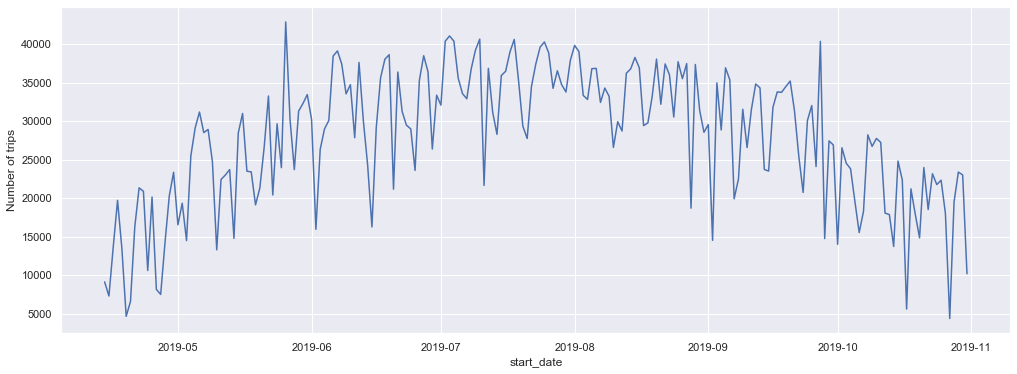

In [35]:
fig, ax = plt.subplots(1, figsize=(17,6))
sns.lineplot(data=trips_per_day, ax=ax)
ax.set_ylabel("Number of trips");

1. Which day had the most trips?
2. Which station was used as 
3. Which station was used as
4. How many trips started and stopped at the same location?
5. Which days of the week are most popular?


In [31]:
print(trips_per_day.idxmax(), trips_per_day.max())
print(trips_per_day.idxmin(), trips_per_day.min())

2019-05-26 42878
2019-10-27 4394


In [43]:
# trips where start == end 
st_e_end = df_trips[(df_trips['start_station_code'] == df_trips['end_station_code'])].shape[0]
print(st_e_end)
print(113015/df_trips.shape[0] )

113015
0.020189019167197376
